In [ ]:
!pip install investpy

In [177]:
import investpy
import pandas as pd
from scipy.stats import norm, mstats
import numpy as np
import matplotlib.pyplot as plt

# Value-at-Risk Estimation and Backtesting

This example shows how to estimate the value-at-risk (VaR) using three methods and perform a VaR backtesting analysis. The three methods are:

- Normal distribution

- Historical simulation

- Exponential weighted moving average (EWMA)

Value-at-risk is a statistical method that quantifies the risk level associated with a portfolio. The VaR measures the maximum amount of loss over a specified time horizon and at a given confidence level.

Backtesting measures the accuracy of the VaR calculations. Using VaR methods, the loss forecast is calculated and then compared to the actual losses at the end of the next day. The degree of difference between the predicted and actual losses indicates whether the VaR model is underestimating or overestimating the risk. As such, backtesting looks retrospectively at data and helps to assess the VaR model.

The three estimation methods used in this example estimate the VaR at 95% and 99% confidence levels.

## Load the Data and Define the Test Window


Load the data. The data used in this example is from a time series of returns on the S&P index from 1993 through 2003.

In [10]:
sp_index = investpy.get_index_historical_data(index='S&P 500',country='United States',from_date='01/01/1993',to_date='1/1/2004')


In [11]:
sp_index

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
1993-01-04,435.7,437.3,434.5,435.4,0,USD
1993-01-05,435.3,435.4,433.6,434.3,0,USD
1993-01-06,434.3,435.2,432.5,434.5,0,USD
1993-01-07,434.5,435.5,429.8,430.7,0,USD
1993-01-08,430.7,430.7,426.9,429.1,0,USD
...,...,...,...,...,...,...
2003-12-24,1096.0,1096.4,1092.7,1094.0,0,USD
2003-12-26,1094.0,1098.5,1094.0,1095.9,0,USD
2003-12-29,1095.9,1109.5,1095.9,1109.5,0,USD


In [78]:
VaRExample  = sp_index[['Close']]
VaRExample.index = pd.to_datetime(VaRExample.index)

In [65]:
def tick2ret(data):
    return data.pct_change(1)

In [66]:
Returns = tick2ret(VaRExample)
DateReturns = Returns.index
SampleSize = Returns.shape[0]

Define the estimation window as 250 trading days. The test window starts on the first day in 1996 and runs through the end of the sample.

In [135]:
TestWindowStart = DateReturns.get_loc('1996').start
TestWindow = list(range(TestWindowStart , SampleSize + 1))
EstimationWindowSize = 250

These values mean that there is at most a 5% and 1% probability, respectively, that the loss incurred will be greater than the maximum threshold (that is, greater than the VaR).

In [121]:
pVaR = [0.05 ,0.01]

## Compute the VaR Using the Normal Distribution Method

For the normal distribution method, assume that the profit and loss of the portfolio is normally distributed. Using this assumption, compute the VaR by multiplying the z-score, at each confidence level by the standard deviation of the returns. Because VaR backtesting looks retrospectively at data, the VaR "today" is computed based on values of the returns in the last N = 250 days leading to, but not including, "today."



In [174]:
Zscore = norm.ppf(pVaR)
Normal95 = np.zeros(len(TestWindow) + 1).reshape(-1,1);
Normal99 = np.zeros(len(TestWindow) + 1).reshape(-1,1);


for t in TestWindow:
    i = t - TestWindowStart + 1
    EstimationWindow = list(range(t-EstimationWindowSize,t-1))
    
    Sigma = np.std(Returns[EstimationWindow[0] : EstimationWindow[-1]+1]); 
    Normal95[i] = -Zscore[0]*Sigma;
    Normal99[i] = -Zscore[1]*Sigma;


Text(0.5, 1.0, 'VaR Estimation Using the Normal Distribution Method')

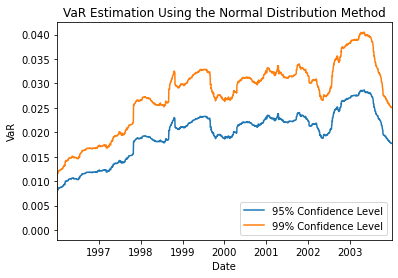

In [175]:
plt.plot(DateReturns[TestWindow[:-1]] , Normal95[:-2] , label = "95% Confidence Level")
plt.plot(DateReturns[TestWindow[:-1]] , Normal99[:-2] , label = "99% Confidence Level")
plt.xlim(DateReturns[TestWindow[0]], DateReturns[TestWindow[-2]])
plt.xlabel('Date')
plt.ylabel('VaR')
plt.legend(loc=4)
plt.title('VaR Estimation Using the Normal Distribution Method')

## Compute the VaR Using the Historical Simulation Method
Unlike the normal distribution method, the historical simulation (HS) is a nonparametric method. It does not assume a particular distribution of the asset returns. Historical simulation forecasts risk by assuming that past profits and losses can be used as the distribution of profits and losses for the next period of returns. The VaR "today" is computed as the p th-quantile of the last N returns prior to "today."

In [178]:
Historical95 = np.zeros(len(TestWindow) + 1).reshape(-1,1);
Historical99 = np.zeros(len(TestWindow) + 1).reshape(-1,1);


for t in TestWindow:
    i = t - TestWindowStart + 1
    EstimationWindow = list(range(t-EstimationWindowSize,t-1))
    
    
    X = Returns[EstimationWindow[0] : EstimationWindow[-1]+1]
    Historical95[i] = -mstats.mquantiles(X,pVaR[0], 0.5, 0.5); 
    Historical99[i] = -mstats.mquantiles(X,pVaR[1], 0.5, 0.5); 


Text(0.5, 1.0, 'VaR Estimation Using the Historical Simulation Method')

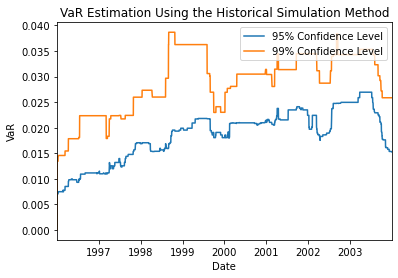

In [180]:
plt.plot(DateReturns[TestWindow[:-1]] , Historical95[:-2] , label = "95% Confidence Level")
plt.plot(DateReturns[TestWindow[:-1]] , Historical99[:-2] , label = "99% Confidence Level")
plt.xlim(DateReturns[TestWindow[0]], DateReturns[TestWindow[-2]])
plt.xlabel('Date')
plt.ylabel('VaR')
plt.legend(loc=1)
plt.title('VaR Estimation Using the Historical Simulation Method')

The preceding figure shows that the historical simulation curve has a piecewise constant profile. The reason for this is that quantiles do not change for several days until extreme events occur. Thus, the historical simulation method is slow to react to changes in volatility.

